
------PART 1-------


Checking accuracy on Training Set


Checking accuracy on Test Set


NOISY



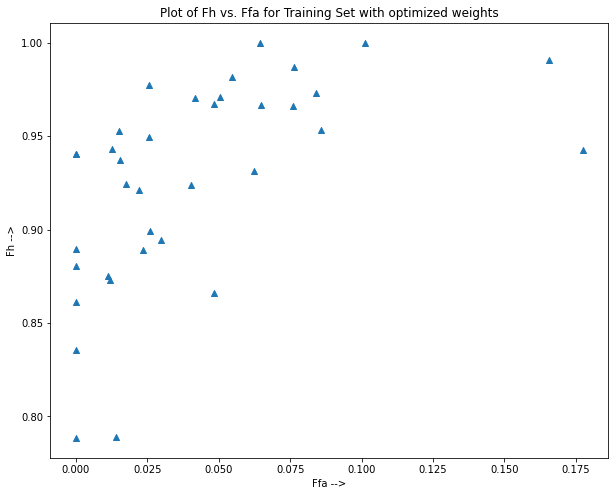

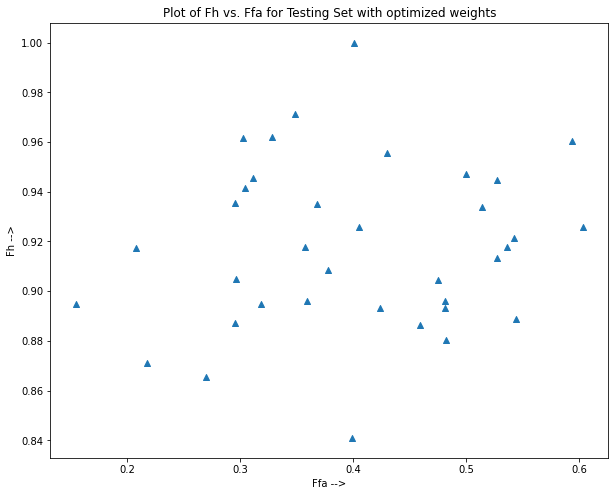

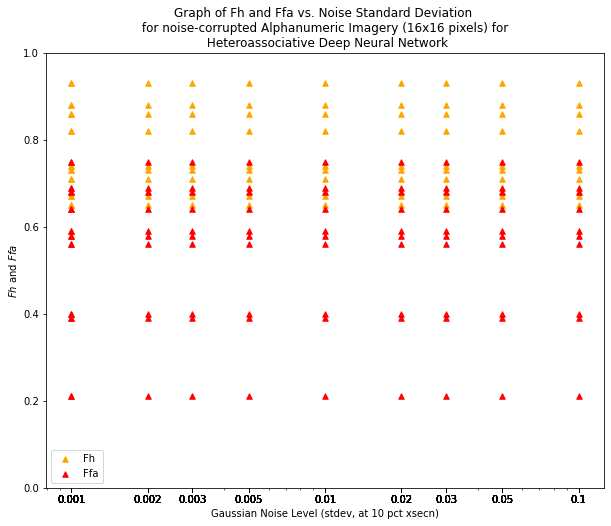


-------PART 2--------


NOISY



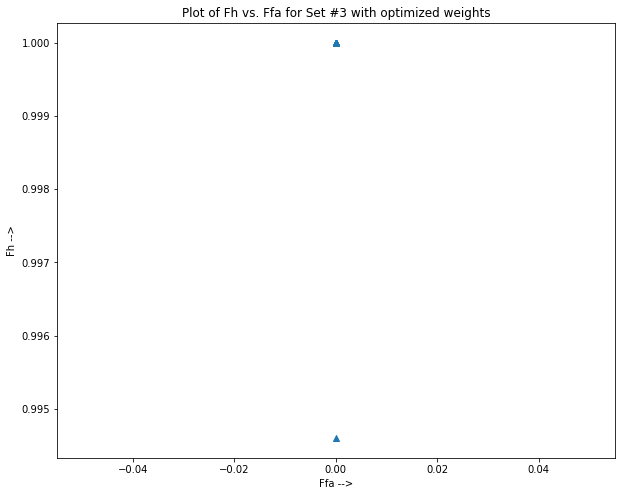

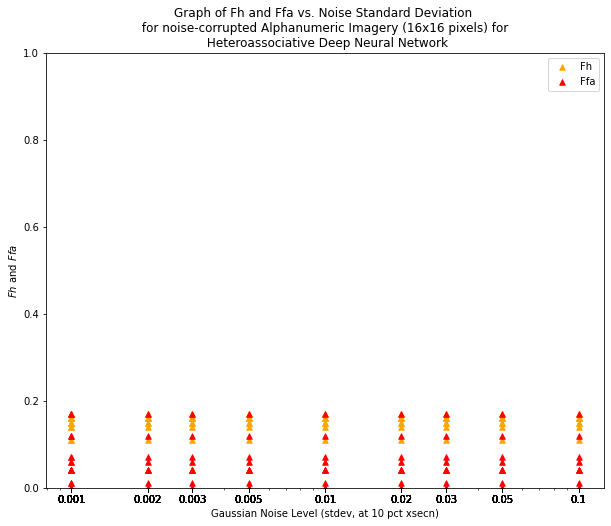

In [9]:
import numpy as np
import os
import sys
from PIL import Image
from matplotlib.pyplot import figure
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import torch
from torch import nn
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader

class MLP1(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      #nn.Linear(4096,1024),
      #nn.Sigmoid(),
      nn.Linear(1024, 1024),
      nn.Sigmoid(),
      nn.Linear(1024,512),
      nn.Tanh(),
      nn.Linear(512,256),
      nn.LeakyReLU(),
      nn.Linear(256,128),
      nn.LeakyReLU(),
      nn.Linear(128,256),
      nn.Sigmoid(),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

def add_noise(outputVector,noise_percent,stdev):
    '''
    Add noise to the output vector.
    '''
    mean = 0
    noise = np.random.normal(mean,stdev,outputVector.shape) * noise_percent
    return outputVector + noise

def Noisy_Testing(stdev, testRounds, inputImageVectors, part2=False):
    '''
    Test the DNN with noise.
    '''
    tableObject = {}
    plotObject = {'fh': [], 'ffa': []}

    for i in range(len(stdev)):
        tableObject['std_'+ str(stdev[i]) + '_fh'] = []
        tableObject['std_'+ str(stdev[i]) + '_ffa'] = []

    for j in range(len(stdev)):   
        for k in range(testRounds) :
            corruptedVector = add_noise(inputImageVectors[k],0.1,stdev[j]) 
            testPrediction = model(torch.from_numpy(corruptedVector.astype('float32'))).detach().numpy()
            for l in range(256):
                if output[l] > 0.01:
                    testPrediction[l] = 1
                else:
                    testPrediction[l] = 0
            fh,ffa = calculate_performance_metrics(inputImageVectors[k],testPrediction)
            # print("FH:", fh, "FFA:", ffa)
            tableObject['std_'+ str(stdev[j]) + '_fh'].append(round(fh,4))
            plotObject['fh'].append(round(fh,2))
            tableObject['std_'+ str(stdev[j]) + '_ffa'].append(round(ffa,4))
            plotObject['ffa'].append(round(ffa,2))
        
    if part2:
        pandas.DataFrame(tableObject).to_csv('test_results2.csv')
    else:
        pandas.DataFrame(tableObject).to_csv('test_results1.csv')

    x = np.array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
                  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
                  0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
                  0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
                  0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
                  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                  0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
                  0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
                  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
                  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
    fig, ax = plt.subplots(figsize=(10,8))
        
    ax.scatter(x, plotObject['fh'], label="Fh", marker= "^", color="orange", s=30)
    ax.scatter(x, plotObject['ffa'], label="Ffa", marker= "^", color="red", s=30)
    
    plt.ylim(0, 1)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tick.FormatStrFormatter('%g'))
    
    
    plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)')
    plt.ylabel("$\it{Fh}$ and $\it{Ffa}$")
    plt.xticks(x)
    plt.title('Graph of Fh and Ffa vs. Noise Standard Deviation \n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for \n Heteroassociative Deep Neural Network')
    plt.legend()
    plt.show()

def Create_Image_Set(filename, ASL):
    ImageVectors = []
    if filename!='ASL32x' and filename!='ASL64x' and ASL==False: #set1 and set2
        for i in range(10):
            path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, str(i) +'.png')
            im = Image.open(path, 'r')
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x<135 else 1, '1')
            ImageVectors.append(np.array(list(bw.getdata())))
        for i in range(26):
            x = i + 65
            path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
            im = Image.open(path, 'r')
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x<135 else 1, '1')
            ImageVectors.append(np.array(list(bw.getdata())))
    
    elif (filename=='ASL32x' or filename=='ASL64x') and ASL==False: #set3
        for i in range(25):
            threshold = 0
            if i==1 or i==2 or i==3 or i==5 or i==6 or i==7 or i==8 or i==9 or i==10 or i==12 or i==13 or i==14 or i==15 or i==16:
                threshold=210
            elif i==18:
                threshold=210
            else:
                threshold=219
            if i!=9:
                path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
                im = Image.open(path, 'r')
                gray = im.convert('L')
                bw = gray.point(lambda x: 0 if x<threshold else 1, '1')
                #plt.figure()
                #plt.imshow(bw)
                ImageVectors.append(np.array(list(bw.getdata())))
    
    elif ASL==True: #set1mod
        for i in range(25):
            if i!=9:
                path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
                im = Image.open(path, 'r')
                gray = im.convert('L')
                bw = gray.point(lambda x: 0 if x<135 else 1, '1')
                ImageVectors.append(np.array(list(bw.getdata())))

    return np.array(ImageVectors)

set1 = Create_Image_Set('characters1',False)
set2 = Create_Image_Set('characters2',False)
set3 = Create_Image_Set('ASL32x',False)
#set3 = Create_Image_Set('ASL64x',False)
set1mod = Create_Image_Set('characters1',True)

imageTensor = torch.Tensor(set1)
_dataSet = TensorDataset(imageTensor, imageTensor)
_dataLoader = DataLoader(_dataSet)

model = MLP1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    losses = []

    for batch_idx, (data, targets) in enumerate(_dataLoader):

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
def calculate_performance_metrics(inputVector, outputVector):
    totalBlackPixelCount = sum(x == 0 for x in inputVector)
    totalWhitePixelCount = sum(x == 1 for x in inputVector)
    wrongBlackPixelCount = 0
    rightBlackPixelCount = 0
    
    for i in range(256):
        if outputVector[i] < 0.0001:
            if  abs(outputVector[i] - inputVector[i]) < 0.0001:
                rightBlackPixelCount += 1
            else:
                wrongBlackPixelCount += 1
    fh = rightBlackPixelCount/totalBlackPixelCount
    ffa = wrongBlackPixelCount/totalWhitePixelCount
    return fh, ffa

def displayTrainingPredictions(predictionDataArray):
    '''
    Display the training predictions.
    '''
    f,axisArray = plt.subplots(len(predictionDataArray),len(predictionDataArray[0]),figsize=(10,10))
    plt.suptitle('SLP Training Set performance')
    for i in range(len(predictionDataArray)):
        for j in range(len(predictionDataArray[0])):
            axisArray[i,j].axes.xaxis.set_visible(False)
            axisArray[i,j].axes.yaxis.set_visible(False)
            if j == 0:
                axisArray[i,j].set_title('Input', fontsize=8,x =0.5,y = 0.9)
            else:
                axisArray[i,j].set_title('Epoch - '+ str(j), fontsize=8, x =0.5,y = 0.9)
            axisArray[i,j].imshow(self.getPredictedImage(predictionDataArray[i][j]))


model.eval()

print("\n------PART 1-------\n")
print("\nChecking accuracy on Training Set\n")

plotObject = {'_fh_plot': [], '_ffa_plot': []}


for i in range(36):
    output = model(torch.from_numpy(set1[i].astype('float32'))).detach().numpy()
    for j in range(256):
        if output[j] > 0:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set1[i], output)
    # print("FH:", fh, "FFA:", ffa)
    plotObject['_fh_plot'].append(round(fh,4))
    plotObject['_ffa_plot'].append(round(ffa,4))

f,axis = plt.subplots(figsize=(10,8))
axis.scatter(x=plotObject['_ffa_plot'],y=plotObject['_fh_plot'],marker="^")
axis.set_xlabel('Ffa -->')
axis.set_ylabel('Fh -->')
axis.set_title('Plot of Fh vs. Ffa for Training Set with optimized weights')

print("\nChecking accuracy on Test Set\n")

plotObject2 = {'_fh_plot': [], '_ffa_plot': []}

for i in range(36):
    output = model(torch.from_numpy(set2[i].astype('float32'))).detach().numpy()
    for j in range(256):
        if output[j] > 0:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set2[i], output)
    # print("FH:", fh, "FFA:", ffa)
    plotObject2['_fh_plot'].append(round(fh,4))
    plotObject2['_ffa_plot'].append(round(ffa,4))

f,axis = plt.subplots(figsize=(10,8))
axis.scatter(x=plotObject2['_ffa_plot'],y=plotObject2['_fh_plot'],marker="^")
axis.set_xlabel('Ffa -->')
axis.set_ylabel('Fh -->')
axis.set_title('Plot of Fh vs. Ffa for Testing Set with optimized weights')


print("\nNOISY\n")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
Noisy_Testing(stdev, 10, set1)

print("\n-------PART 2--------\n")
imageTensor = torch.Tensor(set3)
resultTensor = torch.Tensor(set1mod)
_dataSet = TensorDataset(imageTensor, resultTensor)
_dataLoader = DataLoader(_dataSet,batch_size=2)

model = MLP2()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    losses = []

    for batch_idx, (data, targets) in enumerate(_dataLoader):

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        #print("Loss at this epoch: ",loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

plotObject3 = {'_fh_plot': [], '_ffa_plot': []}

for i in range(24):
    output = model(torch.from_numpy(set3[i].astype('float32'))).detach().numpy()
    #print("Output: ",output," Input: ",set3[i])
    for j in range(256):
        if output[j] > 0.01:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set1mod[i], output)
    #plt.figure()
    #plt.imshow(np.reshape(output,[16,16]))
    # print("FH:", fh, "FFA:", ffa)
    plotObject3['_fh_plot'].append(round(fh,4))
    plotObject3['_ffa_plot'].append(round(ffa,4))

f,axis = plt.subplots(figsize=(10,8))
axis.scatter(x=plotObject3['_ffa_plot'],y=plotObject3['_fh_plot'],marker="^")
axis.set_xlabel('Ffa -->')
axis.set_ylabel('Fh -->')
axis.set_title('Plot of Fh vs. Ffa for Set #3 with optimized weights')

print("\nNOISY\n")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
Noisy_Testing(stdev, 10, set3, True)